# Exploring Temporal GNN Embeddings for Darknet Traffic Analysis
## Final Classification Pipeline
___

## Table of Contents
1. Main Classification Results
2. Impact of History $H$
3. Impact of Training Epochs
4. Visualization

This notebook contains the main codes to run the final k-Nearest-Neighbors classification pipeline. The main experiments are: (i) Main table with classification performance; (ii) impact of History parameter -- temporal aspect of tGNN; (iii) Impact of training epochs for incremental training.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

import sys
sys.path.append('../')

from src.models.classification import KnnClassifier

import warnings
warnings.filterwarnings("ignore")

The following code defines a function classification_pipeline that processes embeddings, performs classification using K-nearest neighbors (KNN) with Leave-One-Out validation, and returns a classification report.

In [2]:
# Load Ground Truth
gt = pd.read_csv('../data/ground_truth/ground_truth.csv')

# Used classes
indices = ['mirai', 'shadowserver', 'driftnet', 'internetcensus', 
           'censys', 'rapid7', 'onyphe', 'netsystems', 'shodan', 
           'securitytrails', 'intrinsec', 'unk_bruteforcer', 
           'unk_spammer', 'unk_exploiter', 'macro avg']

def classification_pipeline(embeddings, active, gt):
    # Get active embeddings
    embeddings = embeddings.loc[active]
    # Manage column names and merge embeddings with labels
    embeddings = embeddings.reset_index().rename(columns={'index':'src_ip'})
    embeddings = embeddings.merge(gt, on='src_ip', how='left')\
                           .fillna('unknown')\
                           .set_index('src_ip')

    # Take classes with more than 10 senders in the considered snapshot
    tmp = embeddings.value_counts('label')
    tmp = tmp[tmp>10].index
    tmp_idx = embeddings[~embeddings.label.isin(tmp)].index
    # Set the others as unknown
    embeddings.loc[tmp_idx, 'label'] = 'unknown'
    
    # Manage X and y datasets
    X_train = embeddings.drop(columns=['label']).values
    y_train = np.ravel(embeddings[['label']].values)
    
    # Initialize the knn
    knn = KnnClassifier(n_neighbors=3, metric='cosine')
    knn.fit(X_train, y_train, scale_data=True)
    
    # Leave-One-Out validation
    to_keep = np.where(y_train!='unknown')[0].reshape(-1, 1)
    y_true = y_train[to_keep]
    y_pred = knn.predict(to_keep, scale_data=True, loo=True) # Pass the indices

    # Get the classification report
    crep = classification_report(
        y_true, 
        y_pred, 
        labels=np.unique(np.ravel(y_true)), 
        output_dict=True
    )
    
    return crep

## 1. Main Classification Results

The following code iterates through each trained model and performs various operations for each column:
1. **Manage file paths** and names based on the column name.
2. **Iterate through days** from 21 to 31: Load a list of active senders from a CSV file and retrieve embeddings from a CSV file. Run a classification pipeline and extracts F1-Scores, then store the F1-Scores in the `reports` list.
3. **Calculate the mean and standard deviation** of F1-Scores.
4. **Organize the results as a dataframe and appends it to the `final_reps` list.
5. **Concatenate** all the dataframes in the `final_reps` list and saves the results to a CSV file.
6. **Display** the resulting dataframe**.

In [21]:
from tqdm.notebook import tqdm_notebook as tqdm

columns = ['iDarkVec', 'GCN', 'iGCN', 'GCNGRU', 'iGCNGRU', 
           'GCN_f', 'iGCN_f', 'GCNGRU_f', 'iGCNGRU_f']

final_reps = []
for col_name in columns:
    # Manage names
    if col_name == 'iDarkVec': 
        emb_path = f'../data/nlp_embeddings/'
        fname = f'{col_name.lower()}_'
    else: 
        emb_path = f'../data/gnn_embeddings/'
        if '_f' in col_name: 
            fname = f'{col_name.lower()[:-2]}_features_'
        else: 
            fname = f'{col_name.lower()}_'

    reports = []
    # For each testing snapshots
    pbar = tqdm(total=len(range(21, 32)))
    for day in range(21, 32):
        pbar.set_description(desc=f'{col_name} -- Day {day}')
        # Load active senders
        active = pd.read_csv(f'../data/raw/raw_202112{day}.csv')\
                   .src_ip.unique()
        
        # Retrieve embeddings
        embeddings = pd.read_csv(
            f'{emb_path}/embeddings_{fname}202112{day}.csv', 
            index_col=[0]
        )
        
        # Run classification and extract F1-Score
        crep = classification_pipeline(embeddings, active, gt)
        reports.append(pd.DataFrame(crep).T['f1-score'])
        pbar.update(1)
        
    # Get mean and std of F1-Score
    mean = pd.concat(reports, axis=1).mean(axis=1, skipna=True)
    std = pd.concat(reports, axis=1).std(axis=1, skipna=True)
    
    # Manage results as a dataframe
    idx = mean.index
    items = [(idx[i], f'{x[0]:.2f}$\pm${x[1]:.2f}') 
                         for i, x in enumerate(zip(mean,std))]
    final_rep = pd.DataFrame(items).set_index(0).rename(columns={1:col_name})
    final_reps.append(final_rep)

# Concatenate everything and save
df = pd.concat(final_reps, axis=1).reindex(indices)
df.to_csv('../data/results/main_results.csv')

df

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,iDarkVec,GCN,iGCN,GCNGRU,iGCNGRU,GCN_f,iGCN_f,GCNGRU_f,iGCNGRU_f
0,,,,,,,,,
mirai,0.98$\pm$0.00,0.63$\pm$0.03,0.76$\pm$0.02,0.69$\pm$0.03,0.72$\pm$0.02,0.98$\pm$0.00,0.98$\pm$0.00,0.88$\pm$0.06,0.98$\pm$0.00
shadowserver,0.96$\pm$0.02,0.14$\pm$0.13,0.49$\pm$0.15,0.64$\pm$0.07,0.49$\pm$0.16,0.91$\pm$0.01,0.90$\pm$0.02,0.95$\pm$0.01,0.96$\pm$0.01
driftnet,0.96$\pm$0.01,0.77$\pm$0.09,0.73$\pm$0.06,0.87$\pm$0.05,0.90$\pm$0.02,0.88$\pm$0.04,0.85$\pm$0.05,0.97$\pm$0.02,0.97$\pm$0.02
internetcensus,0.99$\pm$0.00,0.26$\pm$0.12,0.33$\pm$0.08,0.68$\pm$0.05,0.47$\pm$0.13,0.64$\pm$0.12,0.58$\pm$0.14,0.90$\pm$0.04,0.92$\pm$0.02
censys,0.94$\pm$0.01,0.53$\pm$0.06,0.60$\pm$0.05,0.59$\pm$0.05,0.60$\pm$0.03,0.89$\pm$0.03,0.88$\pm$0.03,0.91$\pm$0.02,0.92$\pm$0.01
rapid7,1.00$\pm$0.00,0.91$\pm$0.05,0.76$\pm$0.11,0.91$\pm$0.02,0.83$\pm$0.10,0.84$\pm$0.04,0.84$\pm$0.02,0.69$\pm$0.47,0.97$\pm$0.04
onyphe,0.96$\pm$0.02,0.06$\pm$0.05,0.05$\pm$0.04,0.11$\pm$0.06,0.05$\pm$0.05,0.93$\pm$0.03,0.93$\pm$0.02,0.92$\pm$0.01,0.91$\pm$0.05
netsystems,0.45$\pm$0.07,0.02$\pm$0.03,0.09$\pm$0.08,0.32$\pm$0.05,0.06$\pm$0.05,0.97$\pm$0.03,0.97$\pm$0.02,0.80$\pm$0.09,0.95$\pm$0.04
shodan,0.88$\pm$0.02,0.12$\pm$0.16,0.14$\pm$0.16,0.23$\pm$0.10,0.10$\pm$0.14,0.81$\pm$0.05,0.79$\pm$0.06,0.76$\pm$0.05,0.79$\pm$0.06


## 2. Impact of History $H$

The following code performs the same classification pipeline of the main results, but only for the i-GCN-GRU model and for different values of the history parameter $H$.

In [20]:
from tqdm.notebook import tqdm_notebook as tqdm

reports = []
emb_path = f'../data/gnn_embeddings/'
for h in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
    if h!=5:
        fname = f'igcngru_features_H{h}_'
    else:
        fname = f'igcngru_features_'
        
    pbar = tqdm(total=len(range(21, 32)))
    # For each testing snapshots
    for day in range(21, 32):
        pbar.set_description(desc=f'H {h} -- Day {day}')
        # Load active senders
        active = pd.read_csv(f'../data/raw/raw_202112{day}.csv')\
                   .src_ip.unique()
        
        # Retrieve embeddings
        embeddings = pd.read_csv(
            f'{emb_path}/embeddings_{fname}202112{day}.csv', 
            index_col=[0]
        )
        
        # Run classification and extract F1-Score
        crep = classification_pipeline(embeddings, active, gt)
        reports.append((h, crep['macro avg']['f1-score']))
        
        pbar.update(1)

# Manage results in dataframe
df = pd.DataFrame(reports, columns=['h', 'f1'])

# Get avg. and std. of F1-Score
df = df.groupby('h')['f1'].agg(['mean', 'std']).reset_index()
df.rename(columns={'mean': 'f1', 'std': 'stdf1'}, inplace=True)

# Get min and max
df['f1min'] = df['f1'] - df['stdf1']
df['f1max'] = df['f1'] + df['stdf1']
df = df.drop(columns=['stdf1'])

# Save
df.to_csv('../data/results/impact_of_history.csv', index=False)

df

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,h,f1,f1min,f1max
0,0,0.729475,0.707881,0.751070
1,1,0.756282,0.736731,0.775833
2,2,0.780522,0.763755,0.797289
3,3,0.791265,0.773972,0.808557
4,4,0.790726,0.775141,0.806310
5,5,0.796390,0.780878,0.811903
6,6,0.793773,0.779929,0.807617
7,7,0.797479,0.781963,0.812995
8,8,0.795375,0.776371,0.814379


## 3. Impact of Training Epochs

The following code performs the same classification pipeline of the main results, but only for the i-GCN-GRU model and for different values of the training epochs used in the incremental training procedure.

In [19]:
from tqdm.notebook import tqdm_notebook as tqdm

reports = []
emb_path = f'../data/gnn_embeddings/'
for epoch in [1, 5, 10, 15, 20, 25, 30]:
    if epoch!=1:
        fname = f'igcngru_features_ee{epoch}_'
    else:
        fname = f'igcngru_features_'
        
    pbar = tqdm(total=len(range(21, 32)))
    # For each testing snapshots
    for day in range(21, 32):
        pbar.set_description(desc=f'Epochs {epoch} -- Day {day}')
        # Load active senders
        active = pd.read_csv(f'../data/raw/raw_202112{day}.csv')\
                   .src_ip.unique()
        
        # Retrieve embeddings
        embeddings = pd.read_csv(
            f'{emb_path}/embeddings_{fname}202112{day}.csv', 
            index_col=[0]
        )
        
        # Run classification and extract F1-Score
        crep = classification_pipeline(embeddings, active, gt)
        reports.append((epoch, crep['macro avg']['f1-score']))
        
        pbar.update(1)

# Manage results in dataframe
df = pd.DataFrame(reports, columns=['epoch', 'f1'])

# Get avg. and std. of F1-Score
df = df.groupby('epoch')['f1'].agg(['mean', 'std']).reset_index()
df.rename(columns={'mean': 'f1', 'std': 'stdf1'}, inplace=True)

# Get min and max
df['f1min'] = df['f1'] - df['stdf1']
df['f1max'] = df['f1'] + df['stdf1']
df = df.drop(columns=['stdf1'])

# Save
df.to_csv('../data/results/impact_of_epochs.csv', index=False)

df

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,epoch,f1,f1min,f1max
0,1,0.796390,0.780878,0.811903
1,5,0.786023,0.774541,0.797506
2,10,0.794721,0.780886,0.808556
3,15,0.788198,0.774631,0.801766
4,20,0.778478,0.762163,0.794793
5,25,0.771929,0.759982,0.783876
6,30,0.759843,0.747208,0.772478


## 4. Visualization

<Figure size 640x480 with 0 Axes>

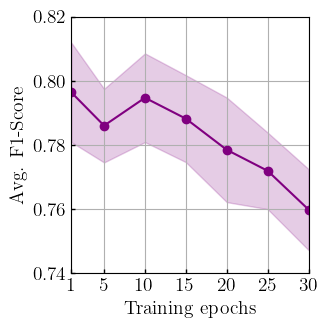

In [2]:
import matplotlib.pyplot as plt
import fastplot
import pandas as pd

df = pd.read_csv('../data/results/impact_of_epochs.csv')

def plotEpochs(plt):
    plt.plot(df.epoch, df.f1, marker='o', label='i-GCN-GRU', 
             color='purple', alpha=1, linestyle='-')
    plt.fill_between(df.epoch, df.f1min, df.f1max, 
             color='purple', alpha=.2)
    
    
    plt.xlabel('Training epochs')
    plt.ylabel('Avg. F1-Score')
    plt.grid()
    plt.xticks([1, 5, 10, 15, 20, 25, 30])
    plt.xlim(1, 30)
    
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', 
                     callback = lambda plt: plotEpochs(plt),
                     figsize=(3.5, 3.5), fontsize=14, style='latex')
plot.show()

<Figure size 640x480 with 0 Axes>

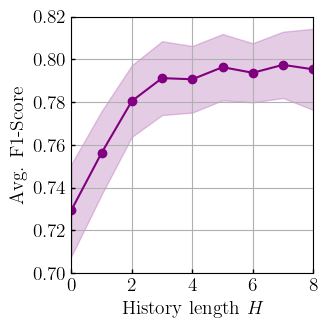

In [6]:
import matplotlib.pyplot as plt
import fastplot
import pandas as pd

df = pd.read_csv('../data/results/impact_of_history.csv')

def plotHistory(plt):
    plt.plot(df.h, df.f1, marker='o', label='i-GCN-GRU', 
             color='purple', alpha=1, linestyle='-')
    plt.fill_between(df.h, df.f1min, df.f1max, 
             color='purple', alpha=.2)
    
    
    plt.xlabel('History length $H$')
    plt.ylabel('Avg. F1-Score')
    plt.grid()
    plt.xticks([0, 2, 4, 6, 8])
    plt.xlim(0, 8)
    
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', 
                     callback = lambda plt: plotHistory(plt),
                     figsize=(3.5, 3.5), fontsize=14, style='latex')
plot.show()